In [1]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
from nwbwidgets.allen import AllenRasterWidget
from nwbwidgets.allen import AllenPSTHWidget
import pandas as pd
import numpy as np
import sys
import os

# Add parent directory to the system path
sys.path.append(os.path.abspath(".."))
from helpers import *
from generate import *
from pathlib import Path
from plot import *

io = NWBHDF5IO('/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/Mice_data/context/AB122_20240804_134554.nwb')
nwbfile = io.read()


""" 
# Load the file with the mice data
nwbfiles = []

paths = ['/Users/shrinidhivelan/Desktop/LSENS - Semester Project/AB077_20230531_143839.nwb', 
        '/Users/shrinidhivelan/Desktop/LSENS - Semester Project/AB087_20231017_141901.nwb']
mouse_names = ['AB077_20230531_143839', 'AB087_20231017_141901']

for path in paths:
    io = NWBHDF5IO(path)
    nwbfiles.append(io.read())

io = NWBHDF5IO('/Users/shrinidhivelan/Desktop/LSENS - Semester Project/AB077_20230531_143839', mode='r')
nwbfile = io.read()
# To do : create a list of mouse names, to be used for the .py file.
mouse_name = 'AB077_20230531_143839'
"""

units = nwbfile.units.to_dataframe()
trials = nwbfile.trials.to_dataframe()


pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Show all columns


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [61]:
def extract_event_times2(nwbfile, type = 'whisker', context = 'passive', has_context = True):
    """
    Extract event times from an NWB file based on stimulus type and context.

    Args:
        nwbfile: NWB file object.
        type (str): The type of event to extract ('whisker', 'auditory', or 'spontaneous_licks').
        context (str): The behavioral context ('passive' or 'active').

    Returns:
        np.ndarray: An array of event times matching the specified type and context.
    """
    # Convert trials table to a DataFrame
    #trials = nwbfile.trials.to_dataframe()
    _, trials = preprocessing(nwbfile)

    if type == 'spontaneous_licks':
        # For spontaneous licks, get event times using a helper function
        _, event_time = filtered_lick_times(nwbfile, 1)
    else:
        if not has_context:
            return trials[(trials[type + '_stim'] == 1)]['start_time'].values
        
        # Extract event times for specified type, context, and lick_flag
        if context == 'active':
            event_time =  trials[
                (trials[type + '_stim'] == 1) &  # Stimulus type must match
                (trials['lick_flag'] == 1) &    # Lick flag must be true
                (trials['context'] == context)  # Context must match
            ]['start_time'].values
        else: 
            event_time = trials[
                (trials[type + '_stim'] == 1) &  # Stimulus type must match
                (trials['context'] == context)  # Context must match
            ]['start_time'].values
    return event_time

In [2]:
df = pd.read_csv('/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/Data/AB122_20240804_134554/AB122_20240804_134554_AUC_Selectivity_pre_post.csv')

df

,cluster_id,ccf_acronym,ccf_name,ccf_parent_id,ccf_parent_acronym,ccf_parent_name,spike_times,mouse_id,context,event,pre_spikes,post_spikes,AUC,Transformed AUC,p-values positive,p-values negative,selective,direction,pre_time,post_time
0,2,GPe,"Globus pallidus, external segment",818.0,PALd,"Pallidum, dorsal region",[ 4.52517635 48.96448943 85.08680182 ......,AB122_20240804_134554,active,whisker,[3 2 0 0 3 3 0 0 0 1 0 1 1 1 0 1 1 0 0 2 2 0 2...,[2 1 0 0 1 1 0 0 0 2 2 2 2 5 1 1 2 1 3 2 2 0 2...,0.513835,0.027669,0.648,0.354,False,none,0.2,0.2
1,8,GPe,"Globus pallidus, external segment",818.0,PALd,"Pallidum, dorsal region",[3.00327339e-02 3.81892378e-01 1.22694218e+00 ...,AB122_20240804_134554,active,whisker,[1 1 1 2 0 0 2 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1...,[1 1 1 1 1 2 1 2 1 1 2 1 1 1 0 1 0 1 0 1 1 1 1...,0.470433,-0.059134,0.986,0.020,True,negative,0.2,0.2
2,11,GPe,"Globus pallidus, external segment",818.0,PALd,"Pallidum, dorsal region",[1.22064230e-01 1.77763119e-01 2.93027485e-01 ...,AB122_20240804_134554,active,whisker,[ 4 6 10 8 1 2 7 5 2 1 9 4 6 2 4 ...,[ 7 10 11 6 1 7 5 9 5 5 9 5 8 6 5 ...,0.650620,0.301240,0.979,0.021,True,negative,0.2,0.2
3,12,GPe,"Globus pallidus, external segment",818.0,PALd,"Pallidum, dorsal region",[2.07029201e-01 4.60024152e-01 4.96090099e-01 ...,AB122_20240804_134554,active,whisker,[0 1 0 0 0 0 0 0 1 0 0 1 1 2 2 3 1 0 1 2 1 1 1...,[0 0 1 1 1 1 0 0 1 0 1 1 1 2 1 0 1 1 2 0 1 1 0...,0.422561,-0.154878,0.648,0.374,False,none,0.2,0.2
4,13,GPe,"Globus pallidus, external segment",818.0,PALd,"Pallidum, dorsal region",[3.20326940e-02 7.85984313e-02 1.00831321e-01 ...,AB122_20240804_134554,active,whisker,[10 8 5 7 6 8 7 8 8 6 7 8 8 5 7 ...,[11 10 7 5 4 8 6 10 7 4 5 8 6 5 10 ...,0.512062,0.024123,0.049,0.951,True,positive,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6365,364,STR,Striatum,623.0,CNU,Cerebral nuclei,[2.44226971e-01 2.51893532e-01 2.54860158e-01 ...,AB122_20240804_134554,NaN,spontaneous_licks,[ 1 7 1 14 2 7 4 7 4 8 2 9 8 2 5 ...,[ 2 4 1 4 2 10 1 0 2 2 2 2 4 2 0 ...,0.424390,-0.151219,0.000,1.000,True,positive,0.2,0.2
6366,368,CEAl,"Central amygdalar nucleus, lateral part",536.0,CEA,Central amygdalar nucleus,[ 16.35097858 32.17559508 59.57817819 ......,AB122_20240804_134554,NaN,spontaneous_licks,[0 0 0 1 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0...,[0 2 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.485803,-0.028393,0.080,0.934,False,none,0.2,0.2
6367,369,CP,Caudoputamen,485.0,STRd,Striatum dorsal region,[ 11.44304414 12.13176266 29.26662012 ......,AB122_20240804_134554,NaN,spontaneous_licks,[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0...,[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0...,0.507067,0.014134,0.747,0.350,False,none,0.2,0.2
6368,374,SSs6a,"Supplemental somatosensory area, layer 6a",378.0,SSs,Supplemental somatosensory area,[ 66.69346958 74.20388986 83.69989681 ......,AB122_20240804_134554,NaN,spontaneous_licks,[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 0 0 0 0 1 0 0...,[0 0 0 1 0 1 0 0 0 1 1 0 5 2 0 1 0 2 0 0 1 2 1...,0.736993,0.473985,1.000,0.000,True,negative,0.2,0.2


In [3]:
df = pd.read_csv('/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/Data/AB122_20240804_134554/AB122_20240804_134554_AUC_Selectivity_pre_post.csv')
#df['context_new'] = df['context'] if df['context'] == "active" else 'passive'
df['context_new'] = df['context'].apply(
    lambda x: 'active' if x == 'active' else 'passive' if x in ['passive_pre', 'passive_post'] else None
)


In [19]:
df = pd.read_csv('/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/Data/Overall/overall_combined.csv')


In [20]:
df['context_new'] = df['context'].apply(
    lambda x: 'active' if x == 'active' else 'passive' if x in ['passive_pre', 'passive_post', 'passive'] else None
)


In [22]:
df

,cluster_id,ccf_acronym,ccf_name,ccf_parent_id,ccf_parent_acronym,ccf_parent_name,spike_times,mouse_id,context,event,pre_spikes,post_spikes,AUC,Transformed AUC,p-values positive,p-values negative,selective,direction,pre_time,post_time,area_acronym,has context,wh_reward,context_new
0,1,CA3,Field CA3,375.0,CA,Ammon's horn,[1.10997831e-02 3.79359254e-01 4.41958031e-01 ...,AB120_20240811_143102,active,whisker,[ 4 3 1 1 4 8 4 6 2 4 5 3 2 5 3 ...,[2 3 5 3 7 2 5 6 3 4 4 4 5 6 5 3 2 7 5 5 3 5 5...,0.557357,0.114714,0.812,0.188,False,none,0.2,0.2,CA3,False,R-,active
1,5,CA3,Field CA3,375.0,CA,Ammon's horn,[8.50683378e-01 8.61316503e-01 8.73749594e-01 ...,AB120_20240811_143102,active,whisker,[ 5 4 3 0 1 7 1 0 1 7 6 1 2 4 3 ...,[ 5 2 8 0 7 3 1 6 5 6 5 2 6 4 6 ...,0.544135,0.088271,0.892,0.108,False,none,0.2,0.2,CA3,False,R-,active
2,9,CA3,Field CA3,375.0,CA,Ammon's horn,[8.57983235e-02 1.90962935e-01 2.93227604e-01 ...,AB120_20240811_143102,active,whisker,[1 2 2 0 0 2 6 4 0 4 2 0 0 1 1 3 0 3 0 3 0 2 3...,[5 1 7 2 4 3 2 3 3 2 5 1 2 5 2 1 2 1 0 1 0 1 2...,0.530008,0.060016,0.879,0.122,False,none,0.2,0.2,CA3,False,R-,active
3,12,CA3,Field CA3,375.0,CA,Ammon's horn,[8.19650651e-02 1.73179949e+00 2.62854864e+00 ...,AB120_20240811_143102,active,whisker,[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0...,[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 3 2 0 0 0 0 0 0...,0.507378,0.014756,0.771,0.247,False,none,0.2,0.2,CA3,False,R-,active
4,14,CA3,Field CA3,375.0,CA,Ammon's horn,[4.24688368e+00 5.92881749e+00 6.04198194e+00 ...,AB120_20240811_143102,active,whisker,[0 1 1 0 1 0 0 1 0 1 2 2 2 2 2 0 2 1 1 5 3 1 2...,[1 0 0 1 1 0 0 1 2 1 0 1 0 0 1 6 2 3 3 3 1 4 4...,0.540908,0.081816,0.861,0.139,False,none,0.2,0.2,CA3,False,R-,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122889,644,SSp-m6a,"Primary somatosensory area, mouth, layer 6a",345.0,SSp-m,"Primary somatosensory area, mouth",[4.82992796e-02 3.64093569e+00 4.10362446e+00 ...,AB107_20240318_121423,NaN,spontaneous_licks,[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1...,[0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0...,0.516441,0.032883,0.941,0.065,False,none,0.2,0.2,SSp-m,True,R+,None
122890,646,SSp-m6a,"Primary somatosensory area, mouth, layer 6a",345.0,SSp-m,"Primary somatosensory area, mouth",[ 4.45451922 5.01817748 5.58706533 ...,AB107_20240318_121423,NaN,spontaneous_licks,[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.492825,-0.014349,0.215,0.818,False,none,0.2,0.2,SSp-m,True,R+,None
122891,647,SSp-m6a,"Primary somatosensory area, mouth, layer 6a",345.0,SSp-m,"Primary somatosensory area, mouth",[3.12295342e-01 3.82394296e-01 5.38191972e-01 ...,AB107_20240318_121423,NaN,spontaneous_licks,[0 0 0 0 0 0 0 0 0 1 0 0 0 4 1 2 1 0 0 1 0 0 2...,[6 3 3 1 2 2 0 0 0 1 0 0 1 2 1 1 1 1 0 1 2 2 1...,0.568878,0.137755,1.000,0.000,True,negative,0.2,0.2,SSp-m,True,R+,None
122892,650,SSp-m5,"Primary somatosensory area, mouth, layer 5",345.0,SSp-m,"Primary somatosensory area, mouth",[1.98969965e+00 2.33309120e+00 3.46880493e+00 ...,AB107_20240318_121423,NaN,spontaneous_licks,[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1...,[1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.532978,0.065957,0.974,0.026,True,negative,0.2,0.2,SSp-m,True,R+,None


In [29]:
direction_value = df[(df['context_new'] == 'active') & 
                     (df['event'] == 'whisker') & 
                     (df['mouse_id'] == 'AB120_20240811_143102') & 
                     (df['cluster_id'] == 1)]#['direction'].iloc[0]
print(direction_value)


   cluster_id ccf_acronym   ccf_name  ccf_parent_id ccf_parent_acronym  \
0           1         CA3  Field CA3          375.0                 CA   

  ccf_parent_name                                        spike_times  \
0    Ammon's horn  [1.10997831e-02 3.79359254e-01 4.41958031e-01 ...   

                mouse_id context    event  \
0  AB120_20240811_143102  active  whisker   

                                          pre_spikes  \
0  [ 4  3  1  1  4  8  4  6  2  4  5  3  2  5  3 ...   

                                         post_spikes       AUC  \
0  [2 3 5 3 7 2 5 6 3 4 4 4 5 6 5 3 2 7 5 5 3 5 5...  0.557357   

   Transformed AUC  p-values positive  p-values negative  selective direction  \
0         0.114714              0.812              0.188      False      none   

   pre_time  post_time area_acronym  has context wh_reward context_new  
0       0.2        0.2          CA3        False        R-      active  


In [18]:
df['event']

0                 whisker
1                 whisker
2                 whisker
3                 whisker
4                 whisker
              ...        
2585    spontaneous_licks
2586    spontaneous_licks
2587    spontaneous_licks
2588    spontaneous_licks
2589    spontaneous_licks
Name: event, Length: 2590, dtype: object

In [8]:
el

636    none
Name: direction, dtype: object

In [54]:
df['context'].unique()

array(['active', 'passive_pre', 'passive_post', nan], dtype=object)

In [12]:
#def Total_PSTH(nwbfile, )

# Start with neuron 0 : 
event_times = extract_event_times(nwbfile, type = 'whisker', context = 'active')
spike_times = units.iloc[1]['spike_times']

In [ ]:
def generate_psth_plots(mouse_name = 'AB122_20240804_134554', main_path = '/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/', has_context = True):
    #mouse_name = 'AB122_20240804_134554'
    #main_path = '/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/'
    plots_path = os.path.join(main_path, 'Plots', 'PSTH')
    passive_path = os.path.join(plots_path, mouse_name, 'passive')
    active_path = os.path.join(plots_path, mouse_name, 'active')
    context = 'context' if has_context else 'nocontext'
    
    nwbfile_path = os.path.join(main_path, 'Mice_data', context)
    nwbfile_path = os.path.join(nwbfile_path, mouse_name+ '.nwb')
    
    io = NWBHDF5IO(nwbfile_path)
    nwbfile = io.read()
    if has_context:
        os.makedirs(passive_path, exist_ok=True)
    os.makedirs(active_path, exist_ok=True)
    units, trials = preprocessing(nwbfile)

    for index, row in units.iterrows():
        spike_times = row['spike_times']
        cluster_nb = row['cluster_id']

        passive_path_save = os.path.join(passive_path, f'{cluster_nb}_passive_cluster.png')
        active_path_save = os.path.join(active_path, f'{cluster_nb}_active_cluster.png')

        #spike_times = units.iloc[15]['spike_times']

        # Parameters for PSTH
        bin_size = 0.01  # 10 ms bin size
        time_start = -0.5  # Start 0.5 seconds before stimulus
        time_stop = 2  # End 2 seconds after stimulus
        artifact_correction = False  # Disable artifact correction for simplicity

        # Separate PSTHs
        active_psths = {}
        passive_psths = {}

        contexts = ['active', 'passive'] if has_context else ['active']

        for context in contexts:

            for event in ['whisker', 'auditory', 'spontaneous_licks']:
                event_times = extract_event_times(nwbfile, type=event, context=context)

                psth = compute_unit_peri_event_histogram(
                    spike_times, event_times, bin_size, time_start, time_stop, artifact_correction
                )

                # Average the histogram across events
                mean_psth = np.mean(psth, axis=0)

                # Store the PSTH based on context and event type
                if context == 'active':
                    active_psths[event] = mean_psth
                elif context == 'passive':
                    passive_psths[event] = mean_psth

        # Create time bins for plotting
        time_bins = np.arange(time_start, time_stop, bin_size)[:len(mean_psth)]

        # Plot Active PSTHs
        plt.figure(figsize=(10, 5))
        for event, mean_psth in active_psths.items():
            plt.plot(time_bins, mean_psth, linewidth=1, alpha=0.7, label=event.capitalize())
        plt.axvline(0, linestyle='--', color='gray', linewidth=0.8)
        plt.xlabel('Time (s)')
        plt.ylabel('Mean Spike Count')
        plt.title('Active Peri-Stimulus Time Histograms (PSTHs)')
        plt.legend(title="Event Type")
        plt.tight_layout()
        plt.savefig(active_path_save, format="png")
        plt.close() 

        if has_context:
            # Plot Passive PSTHs
            plt.figure(figsize=(10, 5))
            for event, mean_psth in passive_psths.items():
                plt.plot(time_bins, mean_psth, linewidth=1, alpha=0.7, label=event.capitalize())
            plt.axvline(0, linestyle='--', color='gray', linewidth=0.8)
            plt.xlabel('Time (s)')
            plt.ylabel('Mean Spike Count')
            plt.title('Passive Peri-Stimulus Time Histograms (PSTHs)')
            plt.legend(title="Event Type")
            plt.tight_layout()
            plt.savefig(passive_path_save, format="png")
            plt.close()  


In [92]:
mouse_names_no_context = ['AB077_20230531_143839','AB080_20230622_152205', 'AB082_20230630_101353',
                   'AB085_20231005_152636', 'AB086_20231015_141742', 'AB087_20231017_141901',
                   'AB092_20231205_140109', 'AB093_20231207_111207', 'AB095_20231212_141728',
                   'AB102_20240309_114107', 'AB104_20240313_145433', 'AB107_20240318_121423']

for mouse in mouse_names_no_context:
    generate_psth_plots(mouse_name = mouse, main_path = '/Volumes/LaCie/EPFL/Mastersem3/Semester Project Lsens/', has_context = False)
    

/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


active


/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shrinidhivelan/miniconda3/envs/Lsens_SP/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


KeyboardInterrupt: 

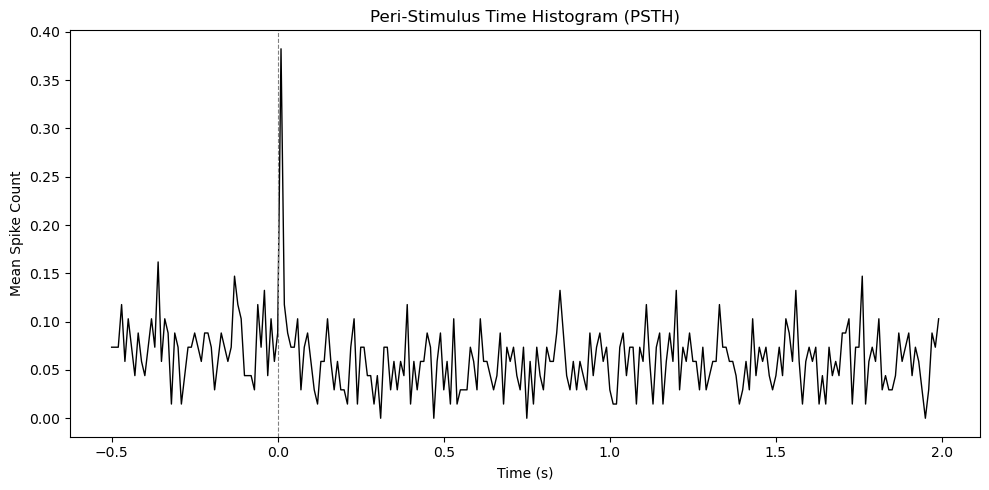

In [62]:
spike_times = units.iloc[10]['spike_times']
event_times = extract_event_times2(nwbfile, type = 'auditory', context = 'passive')


# Call the function to compute the PSTH
bin_size = 0.01  # 10 ms bin size
time_start = -0.5  # Start 100 ms before stimulus
time_stop = 2  # End 100 ms after stimulus
artifact_correction = False  # Disable artifact correction for simplicity

psth = compute_unit_peri_event_histogram(
    spike_times, event_times, bin_size, time_start, time_stop, artifact_correction
)

# Average the histogram across events
mean_psth = np.mean(psth, axis=0)

# Create time bins for plotting
time_bins = np.arange(time_start, time_stop, bin_size)[:mean_psth.size]

# Plot the averaged PSTH using plt.plot
plt.figure(figsize=(10, 5))
plt.plot(time_bins, mean_psth, linewidth=1, color='black')

# Add vertical line for stimulus onset
plt.axvline(0, linestyle='--', color='gray', linewidth=0.8)

# Add labels
plt.xlabel('Time (s)')
plt.ylabel('Mean Spike Count')
plt.title('Peri-Stimulus Time Histogram (PSTH)')

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
spike_data, clusters = Final_spikes_context(units, trials, 0.2, 0.2, True)


In [19]:
spike_data['passive']['whisker']

[[[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  array([-0.04120261]),
  array([-0.13844145, -0.10664209]),
  array([-0.18257467,  0.15075201]),
  array([-0.10911505,  0.18404577]),
  array([-0.0324169 ,  0.02234867]),
  [],
  [],
  array([-0.12249284,  0.16516809]),
  [],
  array([-0.04912151, -0.01852212,  0.11994178]),
  [],
  array([-0.18619295, -0.13749392]),
  array([0.10142056]),
  array([-0.08936165]),
  array([-0.09005631, -0.03812402,  0.13640583]),
  array([-0.12942137, -0.07008922,  0.19217221]),
  array([-0.05517646, -0.03444354,  0.16898573]),
  [],
  array([-0.02032379,  0.06504117]),
  array([-0.1008463 , -0.05358057]),
  array([0.1409418]),
  array([-0.08701388]),
  array([-0.04772837,  0.09336881]),
  array([-0.02864388,  0.07815399,  0.18598517]),
  array([-0.14206062,  0.13546717]),
  array([-0.19277402, -0.02314407,  0.11991974,  0.18245182]),
  array([-0.18718765, -0.18058778, -0.17688785, -0.16635473, -0.16402144,
         -0.13762197, -0.09755

In [24]:
trials

,start_time,stop_time,trial_type,perf,whisker_stim,whisker_stim_amplitude,whisker_stim_duration,whisker_stim_time,auditory_stim,auditory_stim_amplitude,auditory_stim_frequency,auditory_stim_duration,auditory_stim_time,no_stim,no_stim_time,stim_onset,reward_available,response_window_start_time,response_window_stop_time,lick_flag,lick_time,abort_window_start_time,abort_window_stop_time,early_lick,context,context_background,opto_stim,opto_grid_ap,opto_grid_ml,opto_grid_no,opto_stim_start_time,opto_stim_stop_time,opto_stim_amplitude,opto_stim_frequency,trial_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,22.705635,23.805635,auditory_trial,6,0,0.0,0,NaN,1,10,10000,0,22.705635,0,NaN,22.705635,1,22.805635,23.805635,0,NaN,22.705635,22.705635,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,25.823920,26.923920,whisker_trial,6,1,3.2,3,25.823920,0,0,0,0,NaN,0,NaN,25.823920,1,25.923920,26.923920,0,NaN,25.823920,25.823920,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,28.856292,29.956292,whisker_trial,6,1,3.2,3,28.856292,0,0,0,0,NaN,0,NaN,28.856292,1,28.956292,29.956292,0,NaN,28.856292,28.856292,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,31.925298,33.025298,whisker_trial,6,1,3.2,3,31.925298,0,0,0,0,NaN,0,NaN,31.925298,1,32.025298,33.025298,0,NaN,31.925298,31.925298,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,34.998745,36.098745,whisker_trial,6,1,3.2,3,34.998745,0,0,0,0,NaN,0,NaN,34.998745,1,35.098745,36.098745,0,NaN,34.998745,34.998745,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,4005.387284,4006.487284,whisker_trial,6,1,3.2,3,4005.387284,0,0,0,0,NaN,0,NaN,4005.387284,1,4005.487284,4006.487284,0,NaN,4005.387284,4005.387284,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427
428,4008.430656,4009.530656,whisker_trial,6,1,3.2,3,4008.430656,0,0,0,0,NaN,0,NaN,4008.430656,1,4008.530656,4009.530656,0,NaN,4008.430656,4008.430656,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428
429,4011.488732,4012.588732,whisker_trial,6,1,3.2,3,4011.488732,0,0,0,0,NaN,0,NaN,4011.488732,1,4011.588732,4012.588732,0,NaN,4011.488732,4011.488732,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429


In [23]:
# extract event times for each neuron : 
nwbfile

root pynwb.file.NWBFile at 0x6268664912
Fields:
  acquisition: {
    \\sv-nas1.rcp.epfl.ch\Petersen-Lab\data\AB122\Recording\AB122_20240804_134554\Video\AB122_side_cam2 24-08-04 13-45-43.avi <class 'pynwb.image.ImageSeries'>,
    \\sv-nas1.rcp.epfl.ch\Petersen-Lab\data\AB122\Recording\AB122_20240804_134554\Video\AB122_top_cam1 24-08-04 13-45-40.avi <class 'pynwb.image.ImageSeries'>
  }
  devices: {
    imec0 <class 'pynwb.device.Device'>,
    imec1 <class 'pynwb.device.Device'>,
    imec2 <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    imec0_shank0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    imec1_shank0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    imec2_shank0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: {'reference_weight': '26.9', 'session_type': 'ephys_session', 'wh_reward': 0, 'aud_reward': 1, 'reward_proba': 1, 'lick_threshold': 0.03, 'no_stim_weight': 8, 'wh_stim_weight': 10, 'aud_stim_weight': 2, 'camera_flag': 1, 'camera_freq': 200, 'camera_exposure_time': 2, 'camera_start_delay': 3, 'artifact_window': 100}
  experimenter: ['AB']
  file_create_date: [datetime.datetime(2024, 9, 17, 16, 17, 25, 272410, tzinfo=tzoffset(None, 7200))]
  identifier: AB122_20240804_134554
  institution: Ecole Polytechnique Federale de Lausanne
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": shape (5,), type "|O">
  lab: Laboratory of Sensory Processing
  notes: na
  pharmacology: na
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  protocol: na
  related_publications: ['na']
  session_description: whisker_0
  session_id: AB122_20240804_134554
  session_start_time: 2024-08-04 13:45:54+02:00
  slices: na
  source_script: na
  source_script_file_name: na
  stimulus_notes: na
  subject: subject pynwb.file.Subject at 0x6264304656
Fields:
  age: P57D
  age__reference: birth
  date_of_birth: 2024-06-08 00:00:00+02:00
  description: AB122
  genotype: WT
  sex: M
  species: Mus musculus
  strain: C57BL/6
  subject_id: AB122
  weight: 21.7

  surgery: na
  timestamps_reference_time: 2024-08-04 13:45:54+02:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>
  units: units <class 'pynwb.misc.Units'>
  virus: na

In [22]:
units.iloc[0]['spike_times']

array([   4.52517635,   48.96448943,   85.08680182, ..., 4047.63768327,
       4047.86434541, 4048.2108385 ])

### Loading the tables and preprocessing


#### For each line of trials table, we start by testing 10 neurons. In other words, if there is a stimulus (whisker or auditory) at a certain start time then, compute the number of spikes for each trial for each neuron.

In [3]:
units = nwbfile.units.to_dataframe()
trials = nwbfile.trials.to_dataframe()

# Preprocessing s
filtered_units = units[(units['bc_label'] == 'good') & (units['ccf_acronym'].str.contains('[A-Z]'))]


# Some chosen columns
#cons_columns  = ["cluster_id", "firing_rate", "ccf_acronym", "ccf_name", "ccf_parent_acronym", "ccf_parent_name", "spike_times"]#, "lick_flag", "lick_time"]
#filtered_units = filtered_units[cons_columns]

In [112]:
trials[trials['context']=='passive']

,start_time,stop_time,trial_type,perf,whisker_stim,whisker_stim_amplitude,whisker_stim_duration,whisker_stim_time,auditory_stim,auditory_stim_amplitude,auditory_stim_frequency,auditory_stim_duration,auditory_stim_time,no_stim,no_stim_time,stim_onset,reward_available,response_window_start_time,response_window_stop_time,lick_flag,lick_time,abort_window_start_time,abort_window_stop_time,early_lick,context,context_background,opto_stim,opto_grid_ap,opto_grid_ml,opto_grid_no,opto_stim_start_time,opto_stim_stop_time,opto_stim_amplitude,opto_stim_frequency,trial_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,22.705635,23.805635,auditory_trial,6,0,0.0,0,NaN,1,10,10000,0,22.705635,0,NaN,22.705635,1,22.805635,23.805635,0,NaN,22.705635,22.705635,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,25.823920,26.923920,whisker_trial,6,1,3.2,3,25.823920,0,0,0,0,NaN,0,NaN,25.823920,1,25.923920,26.923920,0,NaN,25.823920,25.823920,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,28.856292,29.956292,whisker_trial,6,1,3.2,3,28.856292,0,0,0,0,NaN,0,NaN,28.856292,1,28.956292,29.956292,0,NaN,28.856292,28.856292,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,31.925298,33.025298,whisker_trial,6,1,3.2,3,31.925298,0,0,0,0,NaN,0,NaN,31.925298,1,32.025298,33.025298,0,NaN,31.925298,31.925298,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,34.998745,36.098745,whisker_trial,6,1,3.2,3,34.998745,0,0,0,0,NaN,0,NaN,34.998745,1,35.098745,36.098745,0,NaN,34.998745,34.998745,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,4005.387284,4006.487284,whisker_trial,6,1,3.2,3,4005.387284,0,0,0,0,NaN,0,NaN,4005.387284,1,4005.487284,4006.487284,0,NaN,4005.387284,4005.387284,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427
428,4008.430656,4009.530656,whisker_trial,6,1,3.2,3,4008.430656,0,0,0,0,NaN,0,NaN,4008.430656,1,4008.530656,4009.530656,0,NaN,4008.430656,4008.430656,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428
429,4011.488732,4012.588732,whisker_trial,6,1,3.2,3,4011.488732,0,0,0,0,NaN,0,NaN,4011.488732,1,4011.588732,4012.588732,0,NaN,4011.488732,4011.488732,0,passive,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429


### Whisker &  Stimulation
#### Now iterate in each row of short\_units and create a column with tables to append values for number of spikes for each 

In [6]:
### part 1 : with passive trials
#active_trials = trials[trials['context']] == 'passive'

data = spike_detection(filtered_units, trials, type = 'whisker')
data = spike_detection(data, trials, type = 'auditory')
data = spike_detection(data, trials, type = 'lick_stim', file=nwbfile)

In [ ]:
### part 2 : with active trials
#passive_trials = trials[trials['context']] == 'active'

data = spike_detection(filtered_units, trials, type = 'whisker')
data = spike_detection(data, trials, type = 'auditory')
data = spike_detection(data, trials, type = 'lick_stim', file=nwbfile)

In [ ]:
# Create a new dataframe 
mouse_name = "AB082_20230630_101353.nwb"

data['pre'] = 0.2
data['post'] = 0.2
data['Mouse name'] = mouse_name



folder = f'Data/{mouse_name}'
os.makedirs(folder, exist_ok=True)

#### Only problem : arrays present in columns are converted to string of array, so careful while preprocessing ####

###### It is better to use parquet files ######
#data.to_csv(f'{mouse_name}_Selectivity_Dataframe.csv', index=True, header=True)
#data.to_pickle(f'{mouse_name}_Selectivity_Dataframe.pkl')
data.to_parquet(f'{folder}/{mouse_name}_Selectivity_Dataframe.parquet', index=False)